In [10]:
!pip install flow_matching
!pip install diffusers
# !pip install torchsummary

In [11]:
data_dir = "/kaggle/input/celeba-dataset"

Low Res (Upscaled) Shape: torch.Size([64, 64, 64])
High Res Shape: torch.Size([64, 64, 64])
Low Res Min/Max: tensor(0) tensor(255)
High Res Min/Max: tensor(0) tensor(255)


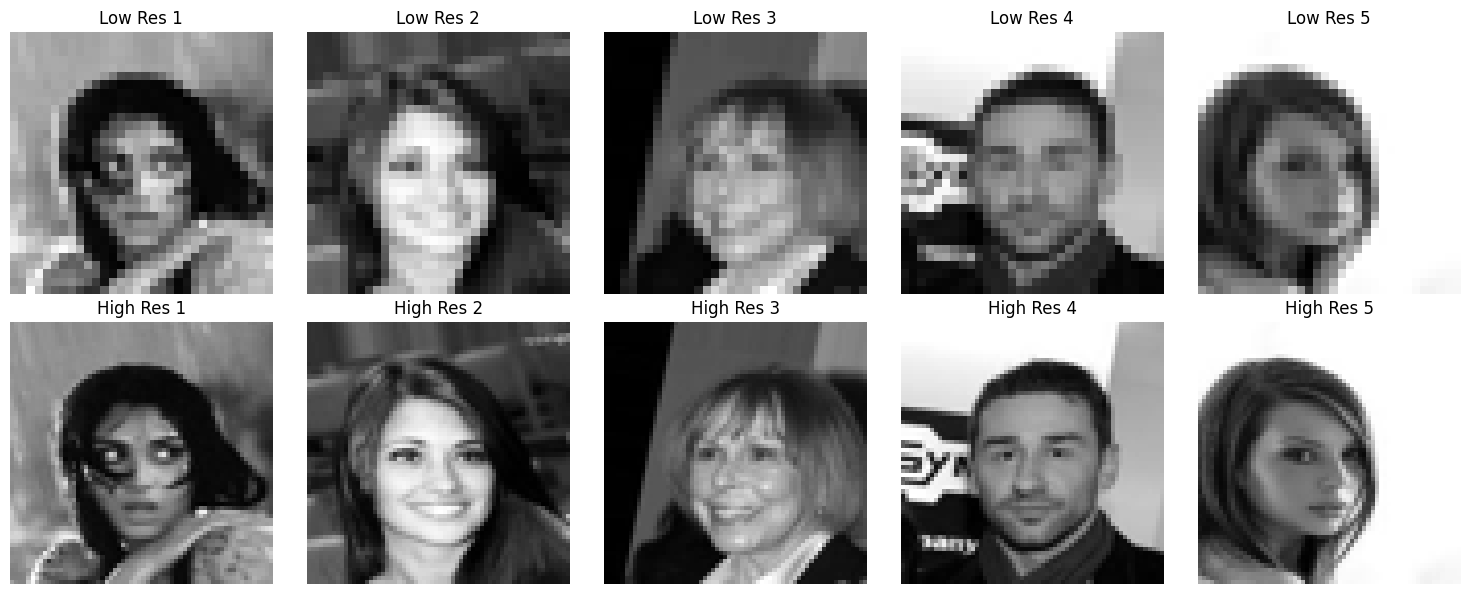

In [12]:
import os
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt

class CelebASuperResolutionDataset(Dataset):
    def __init__(self, root_dir):
        """
        Args:
            root_dir (string): Directory with all the images
        """
        self.image_paths = [
            os.path.join(root_dir, fname) 
            for fname in os.listdir(root_dir) 
            if fname.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]
        
        # Transform for original image (now converting to grayscale)
        self.transform = transforms.Compose([
            transforms.Resize((64, 64), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
            transforms.ToTensor()
        ])
        
        # Transform for low resolution (also grayscale)
        self.low_res_transform = transforms.Compose([
            transforms.Resize((32, 32), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Open image
        img_path = self.image_paths[idx]
        img = Image.open(img_path)
        
        # High resolution image (64x64, grayscale)
        high_res_img = self.transform(img)
        
        # Low resolution image (32x32, grayscale)
        low_res_img = self.low_res_transform(img)
        
        # Upscale low-res image using nearest neighbor interpolation to 64x64
        low_res_upscaled = F.interpolate(
            low_res_img.unsqueeze(0),  # Add batch dimension
            size=(64, 64), 
            mode='nearest'  # Nearest neighbor interpolation
        ).squeeze(0)  # Remove batch dimension
        
        # Convert to 8-bit integer representation and remove channel dimension
        low_res_quantized = (low_res_upscaled.squeeze(0) * 255).to(torch.long)
        high_res_quantized = (high_res_img.squeeze(0) * 255).to(torch.long)
        
        return low_res_quantized, high_res_quantized

def create_celeba_dataloader(
    root_dir='/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba', 
    batch_size=64, 
    num_workers=10
):
    dataset = CelebASuperResolutionDataset(root_dir)
    
    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=num_workers,
        pin_memory=True
    )
    
    return dataloader

def visualize_super_resolution_batch(low_res_batch, high_res_batch, num_images=5):
    """
    Visualize low-resolution and high-resolution images side by side
    
    Args:
    - low_res_batch (torch.Tensor): Batch of low-resolution images
    - high_res_batch (torch.Tensor): Batch of high-resolution images
    - num_images (int): Number of images to visualize
    """
    # Ensure we don't try to visualize more images than in the batch
    num_images = min(num_images, low_res_batch.size(0))
    
    # Create a figure with subplots
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))
    
    for i in range(num_images):
        # Convert tensors to numpy 
        low_res_img = low_res_batch[i].numpy() / 255.0
        high_res_img = high_res_batch[i].numpy() / 255.0
        
        # Plot low-resolution image
        axes[0, i].imshow(low_res_img, cmap='gray')
        axes[0, i].set_title(f'Low Res {i+1}')
        axes[0, i].axis('off')
        
        # Plot high-resolution image
        axes[1, i].imshow(high_res_img, cmap='gray')
        axes[1, i].set_title(f'High Res {i+1}')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    dataloader = create_celeba_dataloader()
    
    for x_0, x_1 in dataloader:
        print("Low Res (Upscaled) Shape:", x_0.shape)   # [64, 64, 64]
        print("High Res Shape:", x_1.shape)  # [64, 64, 64]
        print("Low Res Min/Max:", x_0.min(), x_0.max())
        print("High Res Min/Max:", x_1.min(), x_1.max())
        
        # Visualize the first batch
        visualize_super_resolution_batch(x_0, x_1)
        break


In [13]:
# deeper v2 (with residual block)

class ResidualBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        # Main convolution path
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, 
                                     kernel_size=3, stride=stride, 
                                     padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, 
                                     kernel_size=3, stride=1, 
                                     padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        
        # Shortcut connection
        self.shortcut = torch.nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, 
                                kernel_size=1, stride=stride, bias=False),
                torch.nn.BatchNorm2d(out_channels)
            )
        
        self.relu = torch.nn.SiLU()

    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Shortcut connection
        out += self.shortcut(residual)
        out = self.relu(out)
        
        return out


class SuperResolutionUNet(torch.nn.Module):
    def __init__(self, vocabulary_size=256, h_voc=70): # h_voc = hiden dimention of vacabulary 
        super().__init__()
        
        # Replace initial conv with residual block
        self.input_layer = ResidualBlock(1, 64)

        #self.time_embedding = nn.Linear(1, time_dim)

        # Token embedding (for vocabulary)
        self.token_embedding = torch.nn.Embedding(vocabulary_size, h_voc) # from 256 -> 64

        # Time conditioning (enhanced)
        self.time_conditioning = torch.nn.Sequential(
            torch.nn.Linear(64, 128),
            torch.nn.SiLU(),
            torch.nn.Linear(128, 64)
        )

        # Encoder blocks with Residual Blocks
        self.encoder1 = torch.nn.Sequential(
            ResidualBlock(64, 128),
            torch.nn.MaxPool2d(2)
        )

        self.encoder2 = torch.nn.Sequential(
            ResidualBlock(128, 256),
            torch.nn.MaxPool2d(2)
        )

        self.encoder3 = torch.nn.Sequential(
            ResidualBlock(256, 512),
            torch.nn.MaxPool2d(2)
        )

        self.encoder4 = torch.nn.Sequential(
            ResidualBlock(512, 1024),
            torch.nn.MaxPool2d(2)
        )

        # Decoder blocks with Residual Blocks
        self.decoder4 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            ResidualBlock(512, 512)
        )

        self.decoder3 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            ResidualBlock(256, 256)
        )

        self.decoder2 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            ResidualBlock(128, 128)
        )

        self.decoder1 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            ResidualBlock(64, 64)
        )

        # Final output layer
        self.output_layer = torch.nn.Conv2d(64, vocabulary_size, kernel_size=1)
        


    def forward(self, x, t):

        print("----b")
        print("x.shape", x.shape) # x.shape torch.Size([batch_size, h, w])
        print("t.shape", t.shape) # t.shape torch.Size([batch_size])

        #x = convert_to_onehot(x, vocabulary_size=vocabulary_size)
        #x = convert_with_encoding(x,embedding_dim=100, num_embeddings=vocabulary_size)
        x = self.token_embedding(x)
        
        print("x.shape", x.shape) # x.shape torch.Size([batch_size, h, w, h_voc])
        print("t.shape", t.shape) # t.shape torch.Size([batch_size])

        
        
        #print("max", max(x[0]))
        #print("min", min(x[0]))
        
        # Add channel dimension if not present
        if x.dim() == 2:
            x = x.unsqueeze(0).unsqueeze(0)  # [batch_size, 1, h, w]
        elif x.dim() == 3:
            x = x.unsqueeze(1)  # [batch_size, 1, h, w]
            

        # Ensure input is float
        if x.dtype == torch.long:
            x = x.float() / 255.0

        # Time embedding
        t = self.time_embedding(t.unsqueeze(-1))

        # Initial convolution with residual block
        x = self.input_layer(x)

        # Apply time conditioning
        time_scale = self.time_conditioning(t).view(-1, 64, 1, 1)
        x = x * (1 + time_scale)

        # Encoder
        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        x4 = self.encoder4(x3)

        # Decoder
        x = self.decoder4(x4)
        x = self.decoder3(x + x3)  # Residual-like addition
        x = self.decoder2(x + x2)
        x = self.decoder1(x + x1)

        # Final output layer
        logits = self.output_layer(x)
        logits = logits.permute(0, 2, 3, 1)

        return logits

def convert_to_onehot(x, vocabulary_size=256):
    # Directly create one-hot encoding without normalization
    x_onehot = torch.zeros((*x.shape, vocabulary_size), dtype=torch.float)
    x_rounded = x.long()  # Round to nearest integer
    
    # Use scatter to set the correct indices to 1
    x_onehot.scatter_(-1, x_rounded.unsqueeze(-1), 1)
    
    return x_onehot

def convert_with_encoding(x, embedding_dim, num_embeddings=256):
    embedding = torch.nn.Embedding(num_embeddings, embedding_dim)
    x_rounded = x.long()
    return embedding(x)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FlowMatchingNetwork(nn.Module):
    def __init__(self, in_channels=3, base_channels=64):
        super().__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(base_channels, base_channels*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(base_channels*2, base_channels*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*4),
            nn.LeakyReLU(0.2)
        )
        
        # Flow Matching Module
        self.flow_matching = nn.Sequential(
            nn.Conv2d(base_channels*4, base_channels*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(base_channels*8, base_channels*8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base_channels*8),
            nn.LeakyReLU(0.2)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(base_channels*8, base_channels*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*4),
            nn.ReLU(),
            nn.ConvTranspose2d(base_channels*4, base_channels*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*2),
            nn.ReLU(),
            nn.ConvTranspose2d(base_channels*2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
    
    def forward(self, x, t):
        # Encode input
        encoded = self.encoder(x)
        
        # Flow matching with time conditioning
        t_expanded = t.view(-1, 1, 1, 1).expand_as(encoded)
        flow_input = torch.cat([encoded, t_expanded], dim=1)
        
        # Flow matching module
        flow_features = self.flow_matching(flow_input)
        
        # Decode
        output = self.decoder(flow_features)
        
        return output


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FlowMatchingNetwork(nn.Module):
    def __init__(self, height=64, width=64, vocab_size=256, base_channels=17):
        super().__init__()
        
        # Input dimension handling
        self.height = height
        self.width = width
        self.vocab_size = vocab_size
        
        # Embedding layer for input tokens
        self.token_embedding = nn.Embedding(vocab_size, base_channels)
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(base_channels, base_channels*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(base_channels*2, base_channels*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*4),
            nn.LeakyReLU(0.2)
        )
        
        # Time embedding
        self.time_embedding = nn.Sequential(
            nn.Linear(1, base_channels),
            nn.ReLU(),
            nn.Linear(base_channels, base_channels*2)
        )
        
        # Flow Matching Module
        self.flow_matching = nn.Sequential(
            nn.Conv2d(base_channels*6, base_channels*8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base_channels*8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(base_channels*8, base_channels*8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base_channels*8),
            nn.LeakyReLU(0.2)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(base_channels*8, base_channels*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*4),
            nn.ReLU(),
            nn.ConvTranspose2d(base_channels*4, base_channels*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*2),
            nn.ReLU(),
            nn.ConvTranspose2d(base_channels*2, vocab_size, kernel_size=4, stride=2, padding=1)
        )
    
    def forward(self, x, t):
        # x: [batch_size, height, width, vocab_size]
        # t: [batch_size]
        
        # Embed input tokens
        # Reshape and permute to match conv2d expectations
        #x_embedded = self.token_embedding(x.argmax(dim=-1))  # [batch_size, height, width, base_channels]
        
        x_embedded = self.token_embedding(x) # [batch_size, height, width, base_channels]
        x_embedded = x_embedded.permute(0, 3, 1, 2)  # [batch_size, base_channels, height, width]
        # Encode input
        
        encoded = self.encoder(x_embedded) # [batch_size, base_channels* 4, 16, 16]
        
        # Embed time
        



        t_embedded = self.time_embedding(t.unsqueeze(1))  # [batch_size, base_channels*2]
        
        # Reshape time embedding to match feature map
        #t_expanded = t_embedded.view(t_embedded.size(0), -1, 1, 1).expand_as(encoded)
        t_expanded = t_embedded.view(t_embedded.size(0), -1, 1, 1)
        t_expanded = t_expanded.repeat(1, 1, encoded.shape[2], encoded.shape[3])
        # Concatenate encoded features and time
        flow_input = torch.cat([encoded, t_expanded], dim=1)
        
        # Flow matching
        flow_features = self.flow_matching(flow_input)
        
        # Decode
        output = self.decoder(flow_features)
        
        # Permute to match [batch_size, h, w, vocab_size]
        output = output.permute(0, 2, 3, 1)
        #print("output.shape",output.shape) # output.shape torch.Size([batch_size, 128, 128, vocab_size])
        return output

#x_embedded.shape torch.Size([13, 64, 64, 64])
#t.shape torch.Size([13])
#t_embedded.shape torch.Size([13, 128])
#output.shape torch.Size([13, 128, 128, 256])


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FlowMatchingNetwork(nn.Module):
    def __init__(self, height=64, width=64, vocab_size=256, base_channels=17):
        super().__init__()
        
        # Input dimension handling
        self.height = height
        self.width = width
        self.vocab_size = vocab_size
        
        # Embedding layer for input tokens
        self.token_embedding = nn.Embedding(vocab_size, base_channels)
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(base_channels, base_channels*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(base_channels*2, base_channels*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*4),
            nn.LeakyReLU(0.2)
        )
        
        # Time embedding
        self.time_embedding = nn.Sequential(
            nn.Linear(1, base_channels),
            nn.ReLU(),
            nn.Linear(base_channels, base_channels*2)
        )
        
        # Flow Matching Module
        self.flow_matching = nn.Sequential(
            nn.Conv2d(base_channels*6, base_channels*8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base_channels*8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(base_channels*8, base_channels*8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base_channels*8),
            nn.LeakyReLU(0.2)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(base_channels*8, base_channels*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*4),
            nn.ReLU(),
            nn.ConvTranspose2d(base_channels*4, base_channels*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*2),
            nn.ReLU(),
            nn.ConvTranspose2d(base_channels*2, vocab_size, kernel_size=4, stride=2, padding=1)
        )
    
    def forward(self, x, t):
        # x: [batch_size, height, width, vocab_size]
        # t: [batch_size]
        
        # Embed input tokens
        # Reshape and permute to match conv2d expectations
        #x_embedded = self.token_embedding(x.argmax(dim=-1))  # [batch_size, height, width, base_channels]
        
        x_embedded = self.token_embedding(x) # [batch_size, height, width, base_channels]
        x_embedded = x_embedded.permute(0, 3, 1, 2)  # [batch_size, base_channels, height, width]
        # Encode input
        
        encoded = self.encoder(x_embedded) # [batch_size, base_channels* 4, 16, 16]
        
        # Embed time
        
        t_embedded = self.time_embedding(t.unsqueeze(1))  # [batch_size, base_channels*2]
        
        # Reshape time embedding to match feature map
        #t_expanded = t_embedded.view(t_embedded.size(0), -1, 1, 1).expand_as(encoded)
        
        t_expanded = t_embedded.view(t_embedded.size(0), -1, 1, 1) # [batch_size,  base_channels*2, 1, 1]

        t_expanded = t_expanded.repeat(1, 1, encoded.shape[2], encoded.shape[3]) # [batch_size, base_channels*2, 16, 16]
        print("t_expanded.shape", t_expanded.shape)
        
        # Concatenate encoded features and time
        flow_input = torch.cat([encoded, t_expanded], dim=1) # [batch_size, base_channels*6, 16, 16]
        print("flow_input.shape", flow_input.shape)
        
        
        # Flow matching
        flow_features = self.flow_matching(flow_input) # [batch_size, base_channels*8, 16, 16]
        print("flow_features.shape", flow_features.shape)
        
        
        # Decode
        output = self.decoder(flow_features) # [batch_size, vocab_size, 128, 128]
        print("output.shape", output.shape)
        
        
        # Permute to match [batch_size, h, w, vocab_size]
        output = output.permute(0, 2, 3, 1) #[batch_size, 128, 128, vocab_size]
        print("output.shape",output.shape)
        
        return output


#t_expanded.shape torch.Size()
#t_expanded.shape torch.Size()
#flow_input.shape torch.Size([13, 102, 16, 16])
#flow_features.shape torch.Size()
#output.shape torch.Size([13, 256, 128, 128])
#output.shape torch.Size([13, 128, 128, 256])

In [17]:
# hmmm 
import torch
import torch.nn as nn
import torch.nn.functional as F

class FlowMatchingNetwork(nn.Module):
    def __init__(self, height=64, width=64, vocab_size=256, base_channels=17):
        super().__init__()
        
        # Input dimension handling
        self.height = height
        self.width = width
        self.vocab_size = vocab_size
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(vocab_size, base_channels*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(base_channels*2, base_channels*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*4),
            nn.LeakyReLU(0.2)
        )
        
        # Time embedding
        self.time_embedding = nn.Sequential(
            nn.Linear(1, base_channels),
            nn.ReLU(),
            nn.Linear(base_channels, base_channels*2)
        )
        
        # Flow Matching Module
        self.flow_matching = nn.Sequential(
            nn.Conv2d(base_channels*6, base_channels*8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base_channels*8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(base_channels*8, base_channels*8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base_channels*8),
            nn.LeakyReLU(0.2)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(base_channels*8, base_channels*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*4),
            nn.ReLU(),
            nn.ConvTranspose2d(base_channels*4, base_channels*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*2),
            nn.ReLU(),
            nn.Conv2d(base_channels*2, vocab_size, kernel_size=3, stride=1, padding=1)
        )
    
    def forward(self, x, t):
        # x: [batch_size, height, width, vocab_size]
        # t: [batch_size]
        
        # Prepare input
        x_embedded = x.float().permute(0, 3, 1, 2)  # [batch_size, vocab_size, height, width]
        
        # Encode input
        encoded = self.encoder(x_embedded)
        
        # Embed time
        t_embedded = self.time_embedding(t.unsqueeze(1))  # [batch_size, base_channels*2]
        
        # Reshape time embedding to match feature map
        t_expanded = t_embedded.view(t_embedded.size(0), -1, 1, 1)
        t_expanded = t_expanded.repeat(1, 1, encoded.shape[2], encoded.shape[3])
        
        # Concatenate encoded features and time
        flow_input = torch.cat([encoded, t_expanded], dim=1)
        
        # Flow matching
        flow_features = self.flow_matching(flow_input)
        
        # Decode
        output = self.decoder(flow_features)
        
        # Permute to match [batch_size, h, w, vocab_size]
        output = output.permute(0, 2, 3, 1)
        
        return output

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FlowMatchingNetwork(nn.Module):
    def __init__(self, height=64, width=64, vocab_size=256, base_channels=17):
        super().__init__()
        
        # Input dimension handling
        self.height = height
        self.width = width
        self.vocab_size = vocab_size
        
        # Embedding layer for input tokens
        self.token_embedding = nn.Embedding(vocab_size, base_channels)
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(base_channels, base_channels*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(base_channels*2, base_channels*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*4),
            nn.LeakyReLU(0.2)
        )
        
        # Time embedding
        self.time_embedding = nn.Sequential(
            nn.Linear(1, base_channels),
            nn.ReLU(),
            nn.Linear(base_channels, base_channels*2)
        )
        
        # Flow Matching Module
        self.flow_matching = nn.Sequential(
            nn.Conv2d(base_channels*6, base_channels*8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base_channels*8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(base_channels*8, base_channels*8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base_channels*8),
            nn.LeakyReLU(0.2)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(base_channels*8, base_channels*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*4),
            nn.ReLU(),
            nn.ConvTranspose2d(base_channels*4, base_channels*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*2),
            nn.ReLU(),
ize=3, stride=1, padding=1)

    
    def forward(self, x, t):
        # x: [batch_size, height, width, vocab_size]
        # t: [batch_size]
        
        # Embed input tokens
        x_embedded = self.token_embedding(x)  # [batch_size, height, width, base_channels]
        x_embedded = x_embedded.permute(0, 3, 1, 2)  # [batch_size, base_channels, height, width]
        
        # Encode input
        encoded = self.encoder(x_embedded)
        
        # Embed time
        t_embedded = self.time_embedding(t.unsqueeze(1))  # [batch_size, base_channels*2]
        
        # Reshape time embedding to match feature map
        t_expanded = t_embedded.view(t_embedded.size(0), -1, 1, 1)
        t_expanded = t_expanded.repeat(1, 1, encoded.shape[2], encoded.shape[3])
        
        # Concatenate encoded features and time
        flow_input = torch.cat([encoded, t_expanded], dim=1)
        
        # Flow matching
        flow_features = self.flow_matching(flow_input)
        
        # Decode
        output = self.decoder(flow_features)
        
        # Permute to match [batch_size, h, w, vocab_size]
        output = output.permute(0, 2, 3, 1) # [batch_size, h, w, vocab_size]
        
        return output

In [26]:
# Deeeper

import torch
import torch.nn as nn
import torch.nn.functional as F

class FlowMatchingNetwork(nn.Module):
    def __init__(self, height=64, width=64, vocab_size=256, base_channels=64):
        super().__init__()
        
        # Input dimension handling
        self.height = height
        self.width = width
        self.vocab_size = vocab_size
        
        # Embedding layer for input tokens
        self.token_embedding = nn.Embedding(vocab_size, base_channels)
        
        # Encoder (now deeper)
        self.encoder = nn.Sequential(
            # First block
            nn.Conv2d(base_channels, base_channels*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(base_channels*2, base_channels*2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base_channels*2),
            nn.LeakyReLU(0.2),
            
            # Second block
            nn.Conv2d(base_channels*2, base_channels*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(base_channels*4, base_channels*4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base_channels*4),
            nn.LeakyReLU(0.2),
            
            # Third block
            nn.Conv2d(base_channels*4, base_channels*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(base_channels*8, base_channels*8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base_channels*8),
            nn.LeakyReLU(0.2)
        )
        
        # Time embedding (now deeper)
        self.time_embedding = nn.Sequential(
            nn.Linear(1, base_channels),
            nn.ReLU(),
            nn.Linear(base_channels, base_channels*2),
            nn.ReLU(),
            nn.Linear(base_channels*2, base_channels*4)
        )
        
        # Flow Matching Module (now deeper)
        self.flow_matching = nn.Sequential(
            # First block
            nn.Conv2d(base_channels*12, base_channels*16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base_channels*16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(base_channels*16, base_channels*16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base_channels*16),
            nn.LeakyReLU(0.2),
            
            # Second block
            nn.Conv2d(base_channels*16, base_channels*16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base_channels*16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(base_channels*16, base_channels*16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base_channels*16),
            nn.LeakyReLU(0.2)
        )
        
        # Decoder (now deeper)
        self.decoder = nn.Sequential(
            # First block
            nn.ConvTranspose2d(base_channels*16, base_channels*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*8),
            nn.ReLU(),
            nn.Conv2d(base_channels*8, base_channels*8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base_channels*8),
            nn.ReLU(),
            
            # Second block
            nn.ConvTranspose2d(base_channels*8, base_channels*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*4),
            nn.ReLU(),
            nn.Conv2d(base_channels*4, base_channels*4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base_channels*4),
            nn.ReLU(),
            
            # Third block
            nn.ConvTranspose2d(base_channels*4, base_channels*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*2),
            nn.ReLU(),
            nn.Conv2d(base_channels*2, vocab_size, kernel_size=3, stride=1, padding=1)
        )
    
    def forward(self, x, t):
        # x: [batch_size, height, width, vocab_size]
        # t: [batch_size]
        
        # Embed input tokens
        x_embedded = self.token_embedding(x)  # [batch_size, height, width, base_channels]
        x_embedded = x_embedded.permute(0, 3, 1, 2)  # [batch_size, base_channels, height, width]
        
        # Encode input
        encoded = self.encoder(x_embedded)
        
        # Embed time
        t_embedded = self.time_embedding(t.unsqueeze(1))  # [batch_size, base_channels*4]
        
        # Reshape time embedding to match feature map
        t_expanded = t_embedded.view(t_embedded.size(0), -1, 1, 1)
        t_expanded = t_expanded.repeat(1, 1, encoded.shape[2], encoded.shape[3])
        
        # Concatenate encoded features and time
        flow_input = torch.cat([encoded, t_expanded], dim=1)
        
        # Flow matching
        flow_features = self.flow_matching(flow_input)
        
        # Decode
        output = self.decoder(flow_features)
        
        # Permute to match [batch_size, h, w, vocab_size]
        output = output.permute(0, 2, 3, 1) # [batch_size, h, w, vocab_size]
        
        return output

In [27]:
#model = SuperResolutionUNet(vocabulary_size=256)
model = FlowMatchingNetwork()

# Calculate total parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")


Total parameters: 55573376
Trainable parameters: 55573376


In [28]:

# 5-10 billions params 
# 10 -20 better 
# Exponential movment avarage 

if torch.cuda.is_available():
    device = 'cuda'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu')




Using gpu


In [ ]:
# ver 3 
import torch
import time
from tqdm.auto import tqdm  # For nice progress bars
from flow_matching.path import MixtureDiscreteProbPath, DiscretePathSample
from flow_matching.path.scheduler import PolynomialConvexScheduler
from flow_matching.loss import MixturePathGeneralizedKL
from flow_matching.solver import MixtureDiscreteEulerSolver
from flow_matching.utils import ModelWrapper
from torch import nn
# from torchsummary import summary


# Define a trainable velocity model
#model = SuperResolutionUNet().to(device)

# for paralele to 2 GPUs 
# each batch is slower but epoch is faster) 
#model = SuperResolutionUNet()
#model= nn.DataParallel(model)
#model.to(device)

#
model = FlowMatchingNetwork()
model= nn.DataParallel(model)
model.to(device)
#model = FlowMatchingNetwork().to(device)


optimizer = torch.optim.Adam(model.parameters())
batch_size = 64
dataloader = create_celeba_dataloader(batch_size=batch_size)

# Initialize the scheduler and path for the flow matching
scheduler = PolynomialConvexScheduler(n=2.0)
path = MixtureDiscreteProbPath(scheduler=scheduler)
loss_fn = MixturePathGeneralizedKL(path=path)  # Generalized KL Bregman divergence

# Training parameters
num_epochs = 2  # Number of epochs to train
start_time = time.time()

# Training loop
for epoch in range(num_epochs):
    # Create a progress bar for the epoch
    progress_bar = tqdm(
        dataloader, 
        desc=f'Epoch {epoch + 1}/{num_epochs}', 
        unit='batch',
        colour='green'
    )
    
    epoch_loss = 0.0  # Initialize epoch loss
    num_batches = 0  # Initialize batch counter

    for i, (x_0, x_1) in enumerate(progress_bar):
        batch_size = x_0.shape[0]
        #print('batch_size', batch_size)
        
        x_0, x_1 = x_0.to(device), x_1.to(device)
        
        t = (torch.rand(batch_size) * (1.0 - 1e-3)).to(device)  # Randomize time t ∼ U[0, 1 − 10−3]
        #print()
        
        sample: DiscretePathSample = path.sample(t=t, x_0=x_0, x_1=x_1)  # Sample the conditional path
        
        # Forward pass through the model
        model_output = model(sample.x_t, sample.t)
        #somehow it works with this dim 
        #print("------model_output", model_output.shape)  # torch.Size([batch_size, 128, 128, vocab_size])

        # Calculate the loss
        loss = loss_fn(logits=model_output, x_1=sample.x_1, x_t=sample.x_t, t=sample.t)  # CDFM loss

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()
        num_batches += 1

        # Update the progress bar with current loss
        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}', 
            'Avg Loss': f'{epoch_loss/num_batches:.4f}'
        })

    # Calculate average loss for the epoch
    average_loss = epoch_loss / num_batches
    print(f'Epoch {epoch + 1} completed | Average Loss: {average_loss:.4f}')


Epoch 1/2:   0%|          | 0/3166 [00:00<?, ?batch/s]

In [30]:
# After the training loop
model_save_path = '/kaggle/working/super_resolution_unet.pth'  # Specify the path where you want to save the model

# Save the model's state dictionary
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': num_epochs,
    'loss': average_loss,
}, model_save_path)

print(f'Model saved to {model_save_path}')

Model saved to /kaggle/working/super_resolution_unet.pth


In [31]:
# TODO implement inicialisation a model from .pth file

Sampling completed. Shape of sampled x_pred: torch.Size([2, 64, 64])


<function matplotlib.pyplot.show(close=None, block=None)>

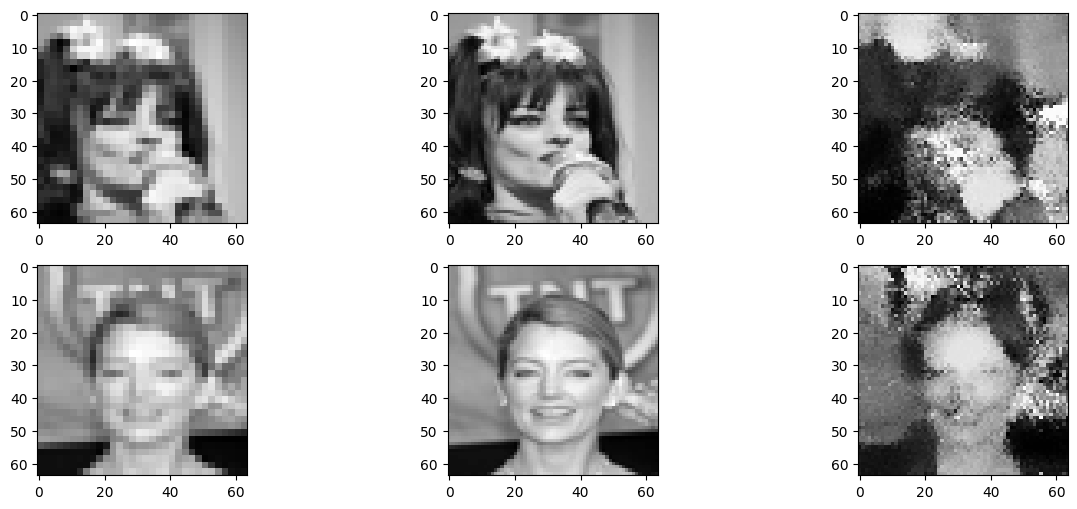

In [32]:
data_dim = (64, 64)  # Height and width of your images
vocabulary_size = 256
n_samples = 1

# Define a probability denoiser model wrapper
class ProbabilityDenoiser(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras) -> torch.Tensor:
        logits = self.model(x, t, **extras)
        return torch.nn.functional.softmax(logits.float(), dim=-1)

# Sample X1 using the trained model
probability_denoiser = ProbabilityDenoiser(model=model)


# Specify the initial condition
# x_0 = torch.randint(0, vocabulary_size, size=[batch_size, *data_dim], device=device)
# print("x_0.shape",x_0.shape) # x_0.shape torch.Size([103, 64, 64])

solver = MixtureDiscreteEulerSolver(
    model=probability_denoiser,
    path=path,
    vocabulary_size=vocabulary_size
)

# x_init = torch.randint(size=(n_samples, *data_dim), high=vocabulary_size, device=device)



# Define the step size and time grid for sampling
step_size = 1 / 50
# x_1 = solver.sample(x_init=x_init, step_size=step_size, time_grid=torch.tensor([0.0, 1.0 - 1e-3], device=device))

# print("Sampling completed. Shape of sampled x_1:", x_1.shape)


batch_size = 2
dataloader = create_celeba_dataloader(batch_size=batch_size)


for x_0, x_1 in dataloader:
    # print("x_0[0].shape",x_0[0].shape) # torch.Size([64, 64])
    x_0 = x_0.to(device)
    
    x_pred = solver.sample(x_init=x_0, step_size=step_size, time_grid=torch.tensor([0.0, 1.0 - 1e-3], device=device))
    print("Sampling completed. Shape of sampled x_pred:", x_pred.shape) # torch.Size([1, 64, 64])
    # print("x_pred[0].shape",x_pred[0].shape) # torch.Size([64, 64])
    break




fig, axes = plt.subplots(batch_size, 3, figsize=(15, 6))

for i in range(batch_size):
    axes[i, 0].imshow(x_0[i].cpu(), cmap='gray') # LR
    axes[i, 1].imshow(x_1[i].cpu(), cmap='gray') # HR
    axes[i, 2].imshow(x_pred[i].cpu(), cmap='gray') # Peredict
    
plt.show


x_0.shape torch.Size([64, 64])
step_size 0.02
linspace_to_plot torch.Size([9])


NFE: 50: 100%|██████████| 0.9990000128746033/0.9990000128746033 [00:00<00:00,  1.11it/s] 


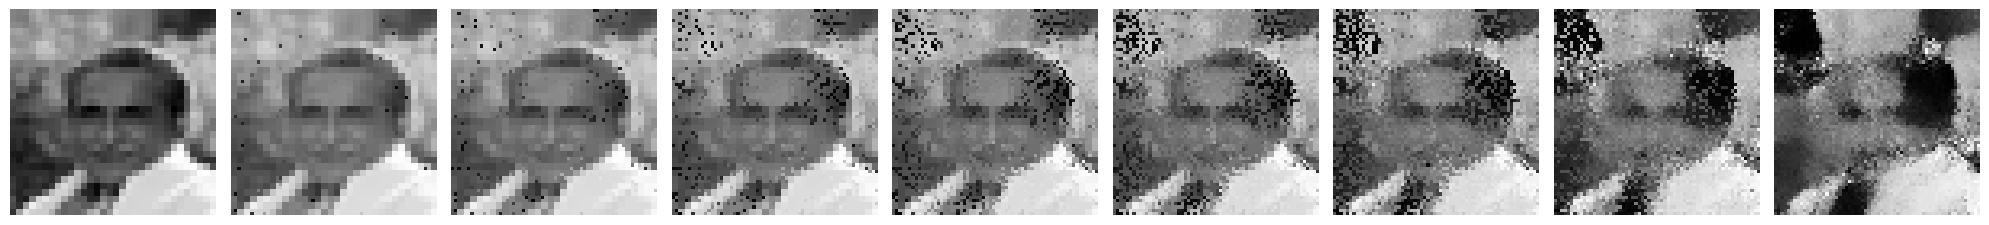

In [33]:
batch_size = 1
dataloader = create_celeba_dataloader(batch_size=batch_size)

dataloader_iter = iter(dataloader)

# Get the first batch of data
x_0, x_1 = next(dataloader_iter)
# print(x_0.shape,x_1.shape)

nfe = 50
step_size = 1 / nfe

safe_sampling = True
n_samples = 1
n_plots = 9
linspace_to_plot = torch.linspace(0.0, 1.0 - 1e-3, n_plots, device=device) # prev 

print("x_0.shape", x_0[0].shape)
print("step_size", step_size)
print("linspace_to_plot", linspace_to_plot.shape )

x_preds = solver.sample(x_init=x_0.to(device),
                        step_size=step_size,
                        verbose=True,
                        return_intermediates=True,
                        time_grid=linspace_to_plot.to(device))

x_preds = x_preds.cpu()

# print("x_preds.shape", x_preds.shape)

fig, axs = plt.subplots(n_samples, n_plots, figsize = (20, 20))

for idx, step in enumerate(linspace_to_plot):
    axs[idx].imshow(x_preds[idx].permute(1, 2, 0).numpy(), cmap='gray')  # Permute to (height, width, channels)
    axs[idx].axis('off')  # Turn off axis
    # fig[idx] = x_preds[idx]
    # step = int(step.item() * nfe)
    # print(idx)
    # print(step)


    
plt.tight_layout()
plt.show()

In [ ]:
# import torch
# import time
# from tqdm.auto import tqdm  # For nice progress bars
# import wandb  # Optional, but great for logging

# # Optional: Initialize wandb for experiment tracking
# wandb.init(project="flow-matching-superres", config={
#     "learning_rate": optimizer.param_groups[0]['lr'],
#     "batch_size": batch_size,
#     "num_epochs": num_epochs
# })

# # Training loop with enhanced verbalization
# for epoch in tqdm(range(num_epochs), desc="Training Epochs", position=0):
#     # Progress bar for batches within each epoch
#     batch_progress = tqdm(
#         enumerate(dataloader), 
#         total=len(dataloader), 
#         desc=f"Epoch {epoch+1}", 
#         position=1, 
#         leave=False
#     )
    
#     epoch_loss = 0.0
#     num_batches = 0

#     for i, (x_0, x_1) in batch_progress:
#         x_0, x_1 = x_0.to(device), x_1.to(device)
        
#         t = (torch.rand(batch_size) * (1.0 - 1e-3)).to(device)
        
#         sample: DiscretePathSample = path.sample(t=t, x_0=x_0, x_1=x_1)
        
#         model_output = model(sample.x_t, sample.t)
#         loss = loss_fn(logits=model_output, x_1=sample.x_1, x_t=sample.x_t, t=sample.t)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         # Update batch progress bar
#         batch_progress.set_postfix({
#             'Loss': f'{loss.item():.4f}', 
#             'LR': f'{optimizer.param_groups[0]["lr"]:.6f}'
#         })

#         epoch_loss += loss.item()
#         num_batches += 1

#     # Calculate and log epoch statistics
#     average_loss = epoch_loss / num_batches
    
#     # Optional: Log to wandb
#     if wandb.run:
#         wandb.log({
#             "epoch": epoch,
#             "avg_loss": average_loss,
#             "learning_rate": optimizer.param_groups[0]['lr']
#         })

#     # Print epoch summary
#     print(f"\nEpoch {epoch+1} Summary:")
#     print(f"Average Loss: {average_loss:.4f}")

# # Optional: Finish wandb run
# if wandb.run:
#     wandb.finish()

In [ ]:
# # old architecture for RGB images 
# class SuperResolutionUNet(torch.nn.Module):
#     def __init__(self, vocabulary_size=256):
#         super().__init__()
#         # Time embedding
#         self.time_embedding = torch.nn.Linear(1, 64)
        
#         # Input layer modified to handle 3 channels
#         self.input_layer = torch.nn.Conv2d(3, 64, kernel_size=3, padding=1)
        
#         # Token embedding (for vocabulary)
#         self.token_embedding = torch.nn.Embedding(vocabulary_size, 64)
        
#         # Time conditioning
#         self.time_conditioning = torch.nn.Sequential(
#             torch.nn.Linear(64, 128),
#             torch.nn.SiLU(),
#             torch.nn.Linear(128, 64)
#         )
        
#         # Main body (UNet-like structure)
#         self.body = torch.nn.Sequential(
#             torch.nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             torch.nn.SiLU(),
#             torch.nn.Conv2d(128, 256, kernel_size=3, padding=1),
#             torch.nn.SiLU()
#         )
        
#         # Output layer for vocabulary prediction
#         self.output_layer = torch.nn.Conv2d(256, vocabulary_size, kernel_size=1)
#         # self.output_layer = torch.nn.Conv2d(256, 3, kernel_size=1)
        
    
#     def forward(self, x, t):
#         # Ensure x is float and in correct range if it's an integer tensor
#         if x.dtype == torch.long:
#             x = x.float() / 255.0
        
#         # Time embedding
#         t = self.time_embedding(t.unsqueeze(-1))
        
#         # Initial convolution
#         x = self.input_layer(x)
        
#         # Apply time conditioning
#         time_scale = self.time_conditioning(t).view(-1, 64, 1, 1)
#         x = x * (1 + time_scale)
        
#         # Process through body
#         x = self.body(x)
        
#         # Output layer
#         logits = self.output_layer(x)
        
        
#         return logits